# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [186]:
import numpy as np
kek = [1,2,2,4,4,4,5,9]
np.argmax(np.bincount(kek))

4

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


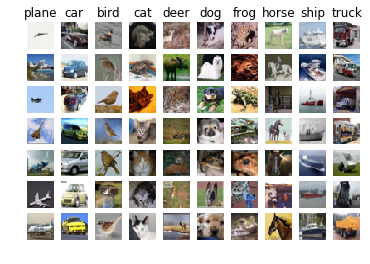

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [8]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


In [9]:
print(X_train[0])
print(X_test[0])
print(np.sqrt(np.sum(np.power(X_test[0] - X_train[0],2))))
dists[0][0]

[ 59.  62.  63. ... 123.  92.  72.]
[158. 112.  49. ...  21.  67. 110.]
3803.92350080808


3803.92350080808

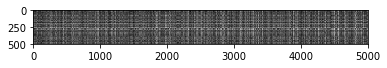

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: Из-за того, что из данных мы выбрали 5000 трейн и 500 тест образцов неравномерно, представители разных типов не уравновешены и поэтому, к примеру, самолетов может быть очень мало, а собак - много. Отсюда мы видим, что некоторые  картинки не подходят ни под один из тренировочных или тестовых образцов. Из-за чего столбец или строка с этой картинкой окрашены в намного более яркий цвет, чем большинство.



In [11]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

1
[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434 4203.28086142
 4354.20256764]
[420]
[4]
[6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194 4694.09767687
 7768.33347636]
[2192]
[9]
[5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853 4464.99921613
 6353.57190878]
[4469]
[8]
[5265.83754022 4274.49459001 4593.32254474 ... 4379.85913015 3793.64455372
 6973.20378305]
[252]
[8]
[3163.80277514 4231.52395716 6134.35889071 ... 4178.39071893 3972.60292504
 3877.14405201]
[1881]
[4]
[3072.51281527 4256.22179873 5351.42317519 ... 3754.21416544 4142.64854894
 3646.74608384]
[2654]
[4]
[4184.89462233 5506.63908387 6925.23934604 ... 5038.19074669 5926.91209653
 4746.98883504]
[4033]
[3]
[3356.5065172  4486.25757174 5965.07007503 ... 4332.44169032 4558.70990523
 3726.08776064]
[910]
[2]
[4473.69858171 4363.13579894 5621.05772964 ... 4681.63112601 3155.1476986
 6142.73107013]
[4808]
[5]
[5739.62167743 4728.38555958 3968.28476801 ... 4002.40752548 4012.45274115
 6834.871

[4645]
[0]
[4074.4653637  4611.44825407 5637.82183117 ... 4224.75218208 3604.17646627
 5209.03023604]
[2982]
[3]
[5836.6478393  5520.70276324 5707.93123645 ... 5032.67632577 4157.20795727
 6481.953255  ]
[2017]
[5]
[4009.05113462 4069.5955573  5090.8657417  ... 3776.36571322 4246.39034946
 3930.03549602]
[4755]
[2]
[3736.9032634  4289.75372253 5181.0497971  ... 3729.25180164 3335.00224887
 4370.74844849]
[254]
[4]
[3539.45885694 5291.16074222 6908.63922925 ... 4889.19093511 4960.48717366
 3392.02962841]
[4108]
[3]
[3309.69741819 3780.79779941 5310.92496652 ... 3480.07212569 3671.43772928
 4509.75819751]
[420]
[4]
[3414.33727098 4040.69523721 5475.8867775  ... 3907.73387016 3028.4436597
 4863.92650027]
[4808]
[5]
[3740.50157065 4983.59117505 6494.35008296 ... 4716.43944093 5029.49679391
 4380.58534901]
[1271]
[3]
[4057.86113612 6073.81379366 7329.25385015 ... 5531.50775106 6597.71073934
 3612.51837366]
[2112]
[6]
[2951.07488892 4665.42066699 6124.73542286 ... 4191.82704796 4198.90402367

You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [12]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

5
[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434 4203.28086142
 4354.20256764]
[ 420 3684 4224 1161 4550]
[4 4 4 6 6]
[6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194 4694.09767687
 7768.33347636]
[2192 4848 2166 2172 3644]
[9 8 8 8 0]
[5224.83913628 4250.64289255 3773.94581307 ... 3766.81549853 4464.99921613
 6353.57190878]
[4469  909 3904 1726  139]
[8 8 8 5 8]
[5265.83754022 4274.49459001 4593.32254474 ... 4379.85913015 3793.64455372
 6973.20378305]
[ 252 4453 4270 2172 3039]
[8 2 0 8 8]
[3163.80277514 4231.52395716 6134.35889071 ... 4178.39071893 3972.60292504
 3877.14405201]
[1881 3949 3797 4604 4262]
[4 5 4 2 4]
[3072.51281527 4256.22179873 5351.42317519 ... 3754.21416544 4142.64854894
 3646.74608384]
[2654  347 1983 2372 4130]
[4 6 5 2 6]
[4184.89462233 5506.63908387 6925.23934604 ... 5038.19074669 5926.91209653
 4746.98883504]
[4033  831   22 3525 1184]
[3 4 6 6 2]
[3356.5065172  4486.25757174 5965.07007503 ... 4332.44169032 4558.70990523
 3726.0877606

[1677 4905 2779 1881 2522]
[2 4 4 4 5]
[5929.91542941 4567.64162342 4233.31973751 ... 4415.51695728 4055.66776253
 7361.15079318]
[2172  406 2192  676 3039]
[8 9 9 1 8]
[4502.82167091 4716.24278425 4694.55620906 ... 4001.04761281 4367.27592442
 4865.59050887]
[1643  420 4577 4066 1264]
[8 4 0 8 4]
[4359.19361809 4282.62979955 4454.2195725  ... 3719.62551879 2589.6275794
 5461.02014279]
[ 982 4527  120 2868 3376]
[4 4 2 2 3]
[4126.95190183 4162.17527262 6035.10024772 ... 4451.35361435 5028.81656058
 5412.58718175]
[1933 2005 2745 3469 3065]
[6 1 5 8 8]
[2595.86575154 4070.73334916 5189.28280208 ... 3308.5582963  3612.86576003
 3208.02665201]
[1838 2812  622 2983 3797]
[2 2 4 2 4]
[4882.27180726 3618.58936604 4095.50277744 ... 3629.90096284 3873.23250012
 5713.92632084]
[1323 1229 4320 1166 4861]
[8 8 8 0 0]
[3285.03652948 4127.35435842 5729.78830324 ... 3749.9346661  4158.03138516
 4204.81830761]
[2730 3797  452 3944 3684]
[5 4 6 2 4]
[4554.90504841 4019.75036538 4511.71574902 ... 3687.

You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*: 4

*Your explanation*: Процедура высчитывания L1 и L2 дистанций отличается и ни один из предложенных методов ни приводит L2 к L1


In [95]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [96]:
print(X_train[0])
print(X_test[0])
dists_one[1]
print(np.sqrt(np.sum(np.power(np.subtract(X_test[0],X_train),2))))

[ 59.  62.  63. ... 123.  92.  72.]
[158. 112.  49. ...  21.  67. 110.]
318501.57929121796


In [13]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')


Difference was: 0.000000
Good! The distance matrices are the same


In [68]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 33.431932 seconds
One loop version took 83.086226 seconds
No loop version took 0.284761 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [17]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_temp = X_train
y_train_temp = y_train
X_train_folds = np.array_split(X_train_temp,num_folds)
y_train_folds = np.array_split(y_train_temp,num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = []
    for fold in range(num_folds):
        classifier.train(np.concatenate([x for i, x in enumerate(X_train_folds) if i != fold]),
                         np.concatenate([y for i, y in enumerate(y_train_folds) if i != fold]))
        y_test_pred = classifier.predict(X_train_folds[fold], k, num_loops=2)
        print(y_test_pred)
        num_correct = np.sum(y_test_pred == y_train_folds[fold])
        accuracy = float(num_correct) / len(y_train_folds[fold])
        print('k: ' + str(k) + ' fold: ' + str(fold) + ' accuracy: ' + str(accuracy) + '\n')
        k_to_accuracies[k].append(accuracy)
        
        
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################



[6. 2. 0. 6. 8. 4. 2. 4. 0. 6. 4. 8. 4. 5. 4. 8. 4. 5. 6. 6. 0. 6. 6. 2.
 3. 2. 2. 3. 4. 8. 0. 0. 1. 4. 2. 2. 0. 7. 8. 2. 8. 2. 3. 3. 2. 4. 5. 0.
 0. 6. 4. 2. 4. 0. 4. 2. 4. 8. 2. 8. 8. 0. 8. 4. 6. 0. 4. 0. 6. 4. 2. 3.
 6. 4. 3. 2. 8. 4. 0. 8. 3. 6. 4. 8. 5. 6. 4. 6. 2. 8. 4. 2. 0. 0. 8. 2.
 1. 4. 5. 4. 2. 2. 4. 5. 6. 9. 0. 2. 2. 8. 8. 2. 8. 7. 3. 8. 8. 4. 7. 1.
 2. 2. 9. 5. 2. 6. 8. 8. 3. 0. 2. 7. 6. 6. 8. 8. 8. 2. 2. 8. 6. 4. 2. 3.
 2. 3. 4. 0. 4. 6. 2. 6. 5. 2. 0. 8. 6. 3. 4. 8. 8. 0. 4. 4. 4. 0. 4. 6.
 3. 0. 2. 7. 2. 6. 0. 3. 4. 4. 4. 6. 6. 6. 3. 6. 0. 8. 6. 2. 3. 8. 8. 2.
 8. 8. 2. 5. 2. 4. 6. 8. 6. 0. 6. 3. 4. 9. 1. 1. 2. 6. 6. 9. 4. 0. 8. 4.
 0. 6. 2. 6. 2. 9. 8. 8. 2. 9. 1. 2. 2. 3. 6. 2. 4. 2. 6. 2. 8. 6. 8. 3.
 8. 6. 2. 2. 0. 4. 0. 4. 4. 7. 1. 4. 8. 2. 6. 6. 4. 0. 6. 9. 6. 2. 8. 2.
 0. 9. 0. 6. 4. 1. 7. 4. 6. 5. 7. 8. 0. 4. 9. 2. 0. 0. 4. 4. 0. 4. 4. 2.
 0. 7. 8. 8. 4. 0. 4. 4. 4. 4. 4. 4. 4. 2. 5. 3. 1. 4. 4. 4. 8. 8. 8. 9.
 8. 6. 2. 3. 9. 2. 7. 1. 4. 3. 0. 1. 4. 8. 6. 4. 8.

[4. 2. 2. 3. 4. 5. 7. 7. 4. 8. 2. 4. 6. 4. 3. 3. 4. 5. 2. 4. 1. 4. 2. 4.
 8. 7. 5. 6. 0. 4. 4. 4. 4. 6. 8. 5. 2. 2. 8. 8. 5. 8. 0. 2. 4. 9. 2. 4.
 6. 2. 4. 2. 2. 0. 4. 6. 2. 3. 8. 9. 3. 2. 1. 9. 4. 4. 0. 2. 4. 2. 0. 9.
 1. 0. 2. 9. 0. 4. 9. 1. 4. 4. 2. 7. 4. 8. 8. 3. 4. 4. 2. 2. 6. 0. 4. 0.
 7. 1. 7. 1. 3. 2. 4. 4. 7. 3. 5. 4. 4. 2. 5. 6. 2. 0. 8. 8. 8. 1. 2. 4.
 4. 8. 6. 4. 3. 2. 8. 9. 0. 9. 8. 4. 8. 4. 3. 4. 6. 8. 2. 4. 0. 4. 6. 1.
 8. 2. 4. 5. 9. 5. 0. 3. 5. 5. 2. 2. 8. 0. 3. 2. 4. 4. 5. 2. 2. 4. 4. 6.
 6. 8. 6. 5. 4. 2. 0. 6. 0. 4. 2. 8. 8. 2. 4. 1. 0. 4. 4. 6. 4. 6. 7. 7.
 6. 2. 2. 0. 2. 0. 4. 8. 2. 1. 8. 4. 5. 0. 6. 4. 6. 2. 4. 0. 9. 4. 0. 8.
 4. 4. 2. 2. 5. 2. 3. 6. 0. 4. 2. 4. 8. 2. 4. 9. 4. 6. 5. 4. 2. 8. 4. 2.
 0. 2. 4. 6. 8. 2. 0. 8. 3. 6. 8. 5. 4. 4. 0. 3. 9. 5. 1. 2. 6. 7. 2. 8.
 5. 6. 6. 4. 8. 9. 0. 6. 7. 4. 2. 7. 5. 0. 0. 4. 8. 4. 2. 4. 2. 9. 7. 6.
 4. 5. 4. 2. 0. 7. 8. 0. 2. 4. 7. 4. 4. 8. 3. 5. 4. 8. 4. 6. 4. 3. 8. 6.
 8. 2. 2. 0. 7. 8. 2. 0. 2. 4. 2. 3. 8. 2. 6. 5. 2.

[7. 2. 6. 2. 2. 4. 2. 4. 2. 0. 2. 8. 0. 4. 2. 3. 2. 0. 4. 4. 8. 1. 0. 4.
 4. 2. 2. 0. 0. 2. 4. 6. 8. 3. 8. 4. 0. 0. 4. 0. 5. 3. 2. 7. 8. 0. 7. 2.
 4. 9. 4. 6. 2. 3. 4. 4. 8. 3. 8. 4. 8. 2. 9. 6. 1. 0. 2. 2. 6. 2. 2. 2.
 2. 3. 3. 2. 5. 6. 2. 1. 8. 2. 0. 0. 0. 3. 0. 7. 3. 2. 3. 3. 8. 2. 2. 5.
 3. 2. 3. 9. 4. 4. 2. 8. 2. 4. 8. 2. 4. 2. 7. 5. 9. 0. 2. 1. 8. 4. 0. 8.
 4. 5. 3. 3. 0. 7. 2. 2. 4. 2. 8. 0. 2. 5. 1. 7. 2. 8. 2. 2. 9. 8. 8. 2.
 0. 1. 4. 8. 4. 4. 2. 0. 2. 6. 6. 2. 2. 2. 0. 2. 2. 0. 8. 0. 2. 2. 8. 0.
 0. 4. 2. 0. 4. 3. 0. 3. 3. 0. 0. 4. 7. 0. 0. 8. 2. 4. 2. 4. 2. 5. 8. 0.
 2. 0. 4. 2. 2. 4. 5. 0. 4. 6. 2. 2. 6. 8. 2. 2. 0. 7. 2. 2. 2. 2. 2. 2.
 8. 6. 4. 2. 6. 0. 5. 2. 4. 2. 7. 2. 4. 8. 8. 9. 2. 0. 0. 8. 8. 4. 2. 4.
 0. 8. 3. 2. 7. 0. 2. 0. 6. 0. 2. 3. 8. 1. 0. 8. 4. 0. 4. 3. 0. 2. 8. 9.
 2. 3. 4. 0. 4. 6. 1. 5. 2. 1. 4. 4. 4. 8. 0. 0. 6. 4. 6. 2. 8. 4. 3. 0.
 2. 8. 4. 6. 8. 1. 4. 0. 8. 0. 2. 0. 3. 4. 4. 4. 2. 8. 8. 6. 2. 1. 5. 3.
 2. 4. 2. 2. 3. 6. 6. 0. 6. 4. 2. 8. 2. 2. 4. 4. 0.

[6. 2. 2. 8. 3. 8. 4. 4. 3. 2. 2. 2. 2. 2. 4. 5. 4. 2. 0. 6. 0. 8. 2. 7.
 2. 3. 6. 2. 8. 8. 0. 2. 4. 2. 0. 0. 8. 2. 2. 4. 0. 4. 4. 2. 2. 0. 0. 1.
 0. 2. 7. 2. 3. 0. 7. 2. 2. 6. 2. 2. 8. 0. 0. 2. 5. 9. 0. 2. 0. 2. 2. 8.
 5. 8. 3. 7. 2. 0. 7. 0. 2. 2. 0. 2. 6. 0. 6. 6. 4. 2. 2. 4. 2. 8. 4. 2.
 8. 4. 2. 3. 2. 4. 6. 6. 4. 4. 2. 0. 4. 2. 0. 1. 4. 0. 4. 2. 3. 3. 3. 0.
 2. 0. 2. 0. 6. 4. 6. 5. 0. 0. 2. 0. 0. 9. 4. 2. 8. 0. 0. 2. 0. 0. 6. 2.
 2. 4. 3. 2. 6. 7. 0. 2. 4. 2. 4. 2. 0. 2. 2. 0. 4. 0. 8. 2. 7. 8. 4. 4.
 2. 8. 0. 0. 2. 4. 0. 0. 2. 2. 4. 4. 4. 4. 2. 0. 4. 2. 4. 0. 2. 4. 0. 0.
 8. 4. 3. 2. 0. 3. 2. 4. 2. 4. 0. 6. 4. 2. 2. 0. 2. 2. 8. 4. 2. 4. 5. 0.
 0. 4. 3. 4. 4. 0. 0. 9. 4. 8. 8. 2. 8. 2. 4. 4. 2. 8. 2. 4. 2. 0. 4. 2.
 8. 0. 2. 2. 4. 0. 0. 4. 2. 2. 0. 0. 6. 2. 2. 2. 8. 0. 0. 4. 2. 6. 4. 4.
 2. 4. 0. 2. 3. 8. 8. 0. 8. 6. 8. 2. 0. 8. 2. 6. 2. 8. 0. 0. 4. 2. 0. 8.
 2. 1. 4. 4. 4. 2. 4. 0. 0. 4. 8. 2. 8. 2. 2. 8. 0. 2. 0. 4. 4. 2. 2. 8.
 4. 0. 2. 2. 8. 2. 5. 8. 8. 5. 0. 6. 4. 2. 3. 2. 3.

[2. 5. 2. 0. 4. 2. 2. 4. 4. 4. 6. 2. 4. 0. 0. 4. 0. 4. 4. 0. 3. 2. 4. 2.
 2. 0. 5. 0. 2. 0. 2. 8. 9. 2. 0. 8. 6. 9. 6. 0. 4. 4. 2. 2. 4. 8. 6. 4.
 3. 3. 2. 4. 4. 4. 2. 4. 4. 3. 4. 0. 8. 8. 8. 0. 2. 8. 2. 2. 3. 2. 4. 2.
 3. 2. 4. 4. 4. 0. 4. 2. 2. 2. 3. 7. 4. 0. 8. 4. 7. 4. 2. 2. 2. 0. 2. 8.
 8. 5. 4. 2. 2. 0. 2. 2. 4. 4. 2. 0. 3. 8. 0. 2. 6. 4. 0. 6. 2. 4. 0. 4.
 3. 4. 6. 2. 4. 3. 4. 3. 4. 9. 4. 4. 4. 2. 6. 0. 2. 4. 0. 2. 4. 8. 0. 4.
 4. 8. 0. 4. 5. 0. 2. 7. 4. 0. 0. 8. 0. 8. 0. 4. 8. 8. 8. 2. 4. 4. 8. 2.
 0. 0. 1. 8. 0. 8. 2. 4. 8. 2. 2. 2. 0. 3. 2. 4. 1. 2. 8. 7. 5. 0. 4. 2.
 8. 0. 3. 4. 4. 4. 2. 4. 0. 4. 2. 4. 8. 2. 4. 2. 2. 8. 4. 2. 8. 2. 0. 2.
 6. 1. 0. 4. 8. 8. 6. 4. 8. 0. 3. 1. 2. 0. 8. 4. 0. 0. 4. 0. 5. 2. 2. 4.
 5. 4. 5. 2. 9. 2. 2. 0. 4. 1. 4. 0. 2. 4. 2. 4. 4. 7. 0. 0. 5. 6. 6. 1.
 0. 0. 2. 9. 1. 0. 2. 3. 8. 2. 4. 8. 6. 0. 4. 8. 0. 2. 4. 4. 2. 8. 0. 0.
 6. 8. 0. 4. 8. 8. 2. 4. 4. 2. 0. 2. 4. 4. 9. 6. 3. 3. 8. 2. 6. 4. 2. 2.
 3. 8. 4. 6. 3. 2. 0. 6. 1. 4. 0. 8. 2. 0. 2. 4. 1.

[2. 0. 9. 6. 8. 4. 4. 7. 2. 2. 4. 8. 0. 3. 2. 0. 0. 4. 0. 3. 0. 6. 6. 4.
 2. 2. 2. 2. 2. 8. 0. 0. 6. 5. 2. 7. 0. 4. 0. 4. 8. 2. 2. 6. 2. 4. 1. 0.
 0. 0. 4. 2. 4. 0. 4. 2. 4. 6. 4. 8. 8. 0. 8. 4. 4. 0. 4. 8. 2. 8. 2. 2.
 6. 4. 6. 4. 8. 6. 3. 0. 0. 4. 4. 8. 4. 6. 4. 4. 2. 4. 2. 2. 2. 0. 8. 2.
 1. 2. 4. 4. 0. 3. 6. 3. 6. 8. 8. 2. 2. 8. 8. 0. 8. 7. 4. 8. 8. 2. 8. 8.
 2. 2. 9. 2. 2. 6. 8. 8. 3. 0. 2. 0. 4. 6. 3. 8. 2. 0. 0. 8. 5. 4. 4. 4.
 2. 4. 4. 0. 4. 4. 2. 2. 0. 2. 8. 0. 2. 3. 4. 2. 1. 8. 6. 6. 2. 0. 4. 4.
 2. 0. 8. 3. 4. 6. 0. 4. 2. 4. 2. 6. 2. 5. 4. 6. 2. 0. 2. 2. 0. 8. 8. 0.
 8. 8. 2. 5. 2. 5. 6. 8. 4. 3. 6. 3. 4. 9. 8. 1. 2. 2. 6. 0. 4. 0. 4. 4.
 0. 6. 2. 6. 2. 8. 0. 7. 2. 9. 1. 2. 4. 5. 5. 2. 2. 2. 4. 2. 2. 4. 8. 2.
 8. 2. 4. 2. 0. 4. 0. 3. 0. 4. 4. 8. 8. 4. 6. 2. 2. 4. 5. 8. 0. 4. 8. 2.
 0. 8. 0. 2. 4. 8. 7. 4. 6. 4. 1. 0. 0. 3. 8. 2. 8. 0. 2. 2. 0. 6. 4. 3.
 2. 2. 8. 4. 4. 8. 6. 9. 7. 4. 4. 2. 2. 4. 2. 2. 4. 2. 4. 2. 0. 0. 8. 9.
 8. 4. 2. 3. 4. 0. 0. 9. 4. 3. 6. 8. 4. 5. 6. 2. 0.

[7. 2. 2. 2. 4. 2. 9. 7. 8. 0. 2. 0. 6. 4. 9. 3. 4. 5. 2. 4. 1. 4. 2. 6.
 0. 0. 5. 4. 0. 4. 4. 4. 0. 6. 8. 6. 4. 2. 8. 8. 4. 3. 0. 5. 4. 9. 2. 0.
 6. 2. 4. 0. 4. 0. 4. 0. 2. 5. 8. 8. 3. 2. 5. 0. 8. 0. 0. 0. 4. 3. 0. 3.
 4. 0. 2. 9. 0. 4. 8. 3. 4. 4. 2. 7. 6. 8. 2. 4. 3. 4. 8. 0. 0. 0. 4. 2.
 4. 3. 0. 4. 4. 2. 4. 4. 4. 6. 3. 4. 4. 4. 5. 6. 2. 0. 8. 8. 4. 8. 2. 2.
 4. 8. 6. 2. 3. 2. 8. 8. 0. 8. 8. 1. 9. 4. 4. 4. 6. 8. 2. 4. 8. 4. 4. 0.
 8. 2. 2. 6. 9. 8. 0. 6. 3. 5. 2. 2. 2. 0. 3. 2. 0. 2. 6. 0. 2. 2. 4. 4.
 6. 8. 2. 5. 4. 5. 8. 8. 0. 3. 2. 8. 8. 2. 4. 1. 0. 6. 4. 6. 4. 6. 4. 2.
 2. 2. 2. 0. 2. 0. 6. 0. 2. 8. 8. 4. 2. 0. 4. 4. 6. 7. 4. 0. 4. 4. 8. 0.
 4. 4. 2. 4. 3. 2. 3. 4. 2. 4. 2. 4. 8. 2. 4. 9. 4. 0. 7. 4. 0. 8. 4. 2.
 8. 2. 2. 2. 8. 6. 8. 8. 2. 6. 8. 0. 4. 2. 2. 2. 9. 4. 8. 0. 2. 7. 2. 0.
 4. 6. 2. 0. 2. 9. 4. 4. 7. 4. 2. 7. 9. 2. 0. 4. 0. 2. 3. 2. 2. 0. 3. 6.
 4. 6. 2. 0. 0. 0. 8. 0. 4. 4. 9. 4. 2. 8. 3. 5. 0. 8. 4. 4. 5. 3. 7. 6.
 8. 8. 2. 0. 7. 2. 2. 0. 2. 6. 4. 6. 8. 2. 2. 5. 2.

[8. 2. 2. 2. 6. 4. 4. 4. 2. 0. 4. 8. 0. 4. 8. 3. 2. 2. 4. 4. 8. 1. 0. 6.
 4. 2. 2. 2. 8. 4. 2. 6. 8. 4. 8. 4. 0. 0. 4. 0. 4. 5. 2. 8. 8. 0. 7. 2.
 4. 0. 4. 6. 2. 3. 4. 4. 8. 3. 8. 4. 8. 2. 2. 6. 1. 0. 2. 2. 6. 2. 2. 2.
 2. 9. 3. 2. 5. 2. 2. 4. 8. 2. 0. 5. 8. 3. 0. 7. 0. 2. 6. 4. 8. 4. 7. 4.
 5. 8. 3. 9. 4. 4. 2. 8. 2. 2. 8. 2. 4. 2. 2. 4. 2. 0. 2. 1. 8. 3. 0. 8.
 4. 6. 3. 2. 4. 7. 4. 3. 3. 2. 0. 0. 2. 5. 6. 7. 4. 8. 2. 2. 7. 8. 8. 2.
 0. 8. 3. 0. 4. 2. 4. 0. 5. 6. 6. 4. 8. 2. 0. 4. 5. 4. 0. 4. 2. 2. 8. 0.
 0. 4. 1. 8. 4. 2. 2. 4. 3. 0. 0. 4. 7. 0. 4. 8. 2. 4. 6. 4. 2. 3. 8. 2.
 2. 0. 4. 4. 3. 4. 3. 0. 4. 6. 2. 4. 4. 2. 0. 2. 3. 2. 4. 0. 4. 5. 0. 2.
 0. 6. 4. 2. 2. 4. 5. 4. 4. 3. 7. 2. 2. 8. 8. 9. 4. 9. 0. 8. 8. 2. 4. 4.
 0. 8. 2. 0. 7. 2. 2. 0. 6. 0. 8. 6. 8. 1. 0. 8. 4. 0. 4. 3. 0. 8. 8. 8.
 2. 3. 6. 2. 4. 6. 8. 5. 3. 8. 4. 4. 4. 8. 8. 2. 4. 4. 6. 2. 8. 4. 3. 4.
 2. 8. 4. 4. 8. 1. 4. 2. 0. 2. 2. 4. 4. 4. 8. 4. 2. 8. 8. 2. 4. 6. 4. 4.
 0. 4. 5. 4. 7. 4. 4. 0. 6. 4. 0. 8. 2. 4. 2. 2. 0.

[8. 2. 2. 9. 6. 8. 4. 2. 9. 2. 6. 6. 5. 4. 4. 4. 4. 2. 8. 6. 2. 8. 4. 2.
 2. 4. 6. 0. 8. 8. 0. 4. 4. 6. 2. 0. 8. 4. 4. 6. 6. 2. 5. 4. 4. 0. 0. 1.
 4. 6. 9. 0. 3. 4. 2. 2. 0. 6. 8. 8. 8. 0. 4. 2. 6. 9. 0. 2. 0. 7. 4. 7.
 5. 9. 5. 7. 7. 4. 7. 0. 0. 2. 8. 2. 6. 0. 2. 3. 2. 2. 2. 4. 4. 8. 4. 2.
 0. 4. 4. 6. 4. 6. 4. 6. 4. 4. 2. 0. 4. 2. 0. 7. 4. 4. 4. 2. 6. 2. 6. 0.
 2. 2. 6. 2. 3. 4. 6. 5. 8. 0. 4. 0. 0. 3. 8. 2. 8. 4. 2. 6. 0. 0. 6. 6.
 2. 2. 4. 4. 6. 5. 2. 2. 2. 4. 4. 0. 2. 0. 2. 8. 4. 2. 8. 0. 7. 8. 3. 4.
 2. 0. 8. 8. 2. 4. 0. 0. 2. 6. 4. 2. 2. 4. 2. 2. 4. 6. 4. 7. 4. 4. 4. 0.
 8. 4. 4. 2. 4. 6. 2. 4. 4. 4. 0. 5. 4. 0. 4. 0. 2. 4. 8. 4. 2. 4. 8. 1.
 0. 6. 2. 4. 4. 0. 8. 8. 4. 8. 8. 2. 8. 0. 4. 4. 4. 8. 4. 2. 2. 2. 0. 2.
 8. 8. 2. 2. 4. 0. 0. 2. 2. 2. 4. 0. 3. 4. 4. 2. 8. 0. 4. 4. 4. 6. 2. 4.
 4. 4. 3. 4. 5. 8. 8. 0. 6. 6. 0. 2. 0. 8. 2. 6. 4. 8. 0. 0. 6. 2. 0. 8.
 2. 4. 6. 4. 5. 2. 4. 0. 8. 4. 8. 4. 8. 4. 2. 8. 0. 4. 0. 4. 4. 2. 2. 0.
 2. 0. 2. 2. 0. 4. 5. 8. 8. 3. 0. 4. 6. 2. 4. 2. 2.

[4. 5. 0. 8. 4. 2. 2. 4. 4. 4. 4. 4. 4. 8. 0. 4. 8. 6. 4. 0. 6. 2. 2. 8.
 2. 0. 5. 0. 3. 0. 2. 8. 4. 2. 0. 8. 4. 9. 6. 2. 2. 4. 0. 4. 2. 8. 2. 6.
 4. 6. 2. 4. 4. 4. 2. 0. 4. 4. 4. 0. 8. 8. 8. 2. 2. 8. 2. 2. 4. 4. 4. 2.
 4. 2. 4. 4. 4. 4. 4. 2. 2. 2. 2. 4. 4. 0. 9. 4. 4. 4. 2. 2. 4. 0. 6. 8.
 8. 4. 4. 4. 2. 2. 4. 2. 4. 4. 2. 0. 4. 8. 8. 2. 6. 4. 3. 6. 2. 4. 0. 4.
 4. 2. 0. 4. 6. 6. 4. 6. 4. 9. 4. 4. 4. 4. 6. 4. 4. 0. 8. 2. 4. 0. 0. 4.
 4. 8. 2. 4. 5. 0. 6. 6. 2. 4. 3. 8. 8. 9. 0. 4. 8. 8. 8. 2. 4. 4. 8. 2.
 2. 0. 9. 8. 8. 8. 2. 4. 8. 2. 4. 2. 8. 2. 2. 4. 1. 2. 2. 1. 2. 0. 4. 2.
 8. 0. 5. 0. 4. 2. 2. 0. 0. 4. 2. 4. 8. 2. 4. 2. 2. 8. 4. 4. 8. 2. 8. 2.
 4. 8. 3. 4. 8. 8. 6. 4. 6. 4. 6. 0. 4. 0. 9. 4. 4. 2. 4. 0. 4. 2. 4. 4.
 8. 4. 3. 4. 7. 2. 8. 0. 4. 8. 4. 0. 4. 4. 3. 4. 4. 4. 0. 4. 5. 5. 4. 6.
 0. 0. 2. 7. 0. 3. 2. 4. 8. 2. 4. 0. 6. 0. 4. 8. 0. 4. 4. 4. 5. 8. 0. 0.
 6. 8. 7. 4. 2. 8. 4. 4. 4. 2. 0. 4. 4. 4. 9. 6. 6. 3. 8. 5. 6. 8. 2. 2.
 3. 8. 4. 6. 2. 2. 0. 4. 1. 4. 2. 8. 4. 8. 2. 4. 9.

[2. 8. 9. 6. 8. 4. 4. 4. 0. 1. 2. 8. 0. 3. 2. 8. 8. 4. 6. 2. 0. 6. 6. 4.
 2. 2. 6. 2. 4. 8. 2. 0. 4. 5. 2. 7. 2. 2. 0. 4. 2. 2. 2. 6. 2. 4. 1. 0.
 2. 0. 4. 2. 4. 0. 6. 2. 4. 6. 4. 8. 8. 2. 8. 2. 4. 8. 4. 8. 2. 8. 2. 2.
 7. 6. 2. 4. 8. 2. 2. 0. 2. 4. 4. 8. 4. 6. 4. 4. 4. 4. 2. 4. 0. 8. 0. 2.
 0. 2. 2. 6. 0. 2. 6. 3. 6. 8. 8. 6. 2. 8. 8. 2. 4. 7. 6. 8. 8. 2. 8. 8.
 2. 2. 9. 2. 4. 6. 8. 8. 6. 0. 4. 8. 4. 6. 2. 8. 2. 8. 2. 8. 6. 2. 4. 2.
 2. 4. 4. 0. 4. 4. 4. 2. 0. 2. 8. 8. 2. 4. 4. 2. 8. 8. 6. 6. 6. 0. 4. 4.
 4. 3. 8. 3. 0. 2. 6. 4. 4. 4. 2. 6. 2. 5. 4. 4. 2. 0. 2. 2. 8. 8. 8. 0.
 8. 8. 2. 4. 2. 4. 6. 8. 2. 1. 1. 0. 4. 9. 8. 8. 7. 2. 2. 0. 4. 0. 4. 4.
 0. 6. 4. 8. 0. 8. 8. 8. 2. 4. 9. 2. 4. 5. 2. 0. 2. 2. 4. 4. 2. 4. 8. 2.
 8. 2. 2. 2. 0. 4. 2. 4. 2. 4. 2. 8. 8. 4. 6. 2. 2. 8. 5. 9. 2. 6. 8. 2.
 0. 8. 2. 2. 4. 8. 9. 4. 2. 4. 1. 2. 0. 2. 8. 2. 8. 0. 2. 2. 8. 6. 4. 4.
 2. 2. 8. 4. 4. 8. 6. 9. 2. 4. 4. 2. 4. 4. 2. 0. 4. 4. 4. 4. 8. 8. 8. 7.
 2. 4. 2. 3. 9. 0. 7. 9. 4. 3. 6. 8. 4. 0. 6. 4. 0.

[7. 2. 2. 3. 6. 6. 8. 7. 8. 0. 2. 8. 6. 4. 9. 6. 4. 4. 2. 4. 1. 4. 2. 6.
 0. 2. 5. 4. 0. 2. 4. 4. 0. 7. 8. 6. 2. 2. 0. 8. 4. 3. 0. 2. 4. 9. 2. 6.
 6. 2. 4. 8. 4. 0. 4. 0. 4. 5. 8. 8. 5. 2. 2. 8. 8. 2. 0. 0. 7. 3. 4. 3.
 8. 0. 2. 9. 0. 4. 8. 8. 2. 4. 5. 7. 4. 8. 2. 4. 4. 4. 8. 2. 0. 0. 4. 2.
 2. 0. 2. 4. 4. 2. 4. 4. 4. 6. 6. 4. 4. 2. 5. 6. 2. 0. 8. 8. 4. 8. 2. 2.
 4. 8. 6. 2. 6. 2. 8. 8. 0. 8. 8. 1. 8. 3. 4. 4. 6. 8. 2. 4. 8. 2. 4. 7.
 8. 4. 2. 6. 9. 8. 8. 4. 3. 5. 2. 4. 2. 0. 0. 2. 2. 2. 6. 2. 2. 2. 4. 4.
 6. 8. 6. 5. 4. 2. 8. 8. 0. 3. 2. 8. 8. 2. 4. 1. 0. 4. 4. 6. 4. 6. 4. 2.
 4. 2. 2. 0. 2. 0. 2. 8. 2. 8. 8. 4. 2. 0. 6. 4. 0. 7. 4. 0. 6. 4. 8. 0.
 4. 4. 2. 4. 6. 2. 4. 4. 2. 4. 2. 4. 8. 2. 4. 9. 2. 2. 7. 4. 0. 8. 4. 2.
 8. 2. 2. 2. 8. 4. 8. 0. 2. 6. 8. 0. 4. 2. 2. 2. 9. 4. 8. 0. 2. 7. 2. 0.
 4. 6. 2. 0. 4. 8. 4. 4. 7. 2. 2. 7. 9. 2. 0. 4. 8. 2. 2. 2. 2. 0. 6. 6.
 4. 6. 2. 0. 8. 0. 8. 4. 4. 4. 9. 4. 2. 8. 3. 4. 8. 8. 4. 4. 5. 6. 8. 6.
 8. 8. 2. 8. 7. 2. 2. 0. 2. 2. 2. 3. 8. 4. 2. 6. 2.

[8. 2. 2. 2. 6. 2. 4. 2. 2. 0. 4. 8. 4. 4. 8. 3. 2. 2. 2. 4. 8. 9. 0. 6.
 2. 2. 2. 2. 8. 4. 2. 4. 8. 4. 8. 4. 0. 0. 4. 0. 4. 5. 4. 8. 8. 0. 7. 4.
 2. 8. 4. 6. 2. 6. 7. 4. 8. 3. 0. 4. 8. 2. 0. 6. 1. 2. 2. 2. 6. 2. 4. 2.
 2. 3. 3. 2. 4. 2. 7. 4. 8. 2. 0. 6. 8. 2. 0. 7. 4. 2. 3. 4. 8. 4. 7. 4.
 5. 9. 3. 8. 2. 4. 2. 8. 2. 2. 8. 2. 6. 4. 4. 5. 2. 0. 2. 8. 8. 2. 0. 8.
 2. 5. 4. 2. 2. 7. 4. 4. 5. 2. 0. 0. 2. 6. 6. 7. 6. 8. 2. 8. 9. 8. 0. 2.
 0. 0. 6. 0. 4. 7. 8. 8. 5. 6. 6. 4. 8. 4. 0. 4. 4. 4. 0. 2. 2. 4. 8. 0.
 0. 4. 4. 8. 4. 2. 4. 6. 3. 2. 0. 4. 7. 0. 4. 8. 2. 4. 6. 4. 2. 3. 8. 0.
 2. 4. 2. 8. 8. 4. 3. 0. 4. 6. 4. 4. 6. 2. 2. 2. 3. 2. 4. 0. 2. 2. 0. 2.
 8. 6. 4. 0. 2. 4. 5. 4. 4. 3. 7. 2. 2. 8. 8. 8. 4. 9. 8. 8. 8. 4. 2. 4.
 2. 8. 2. 2. 2. 2. 2. 4. 6. 0. 8. 4. 8. 1. 0. 8. 4. 4. 4. 6. 0. 8. 0. 8.
 0. 4. 6. 4. 4. 4. 8. 4. 6. 2. 2. 4. 4. 8. 8. 2. 4. 4. 4. 2. 8. 2. 3. 8.
 2. 8. 4. 4. 8. 1. 4. 2. 0. 2. 0. 4. 4. 4. 8. 4. 2. 8. 8. 4. 2. 6. 4. 4.
 2. 4. 4. 2. 7. 4. 4. 0. 6. 4. 8. 8. 6. 4. 2. 4. 0.

[8. 0. 2. 9. 6. 8. 4. 2. 2. 2. 6. 4. 5. 4. 4. 4. 8. 2. 8. 6. 2. 8. 2. 2.
 4. 4. 4. 0. 8. 0. 0. 4. 4. 4. 2. 0. 8. 2. 2. 4. 2. 4. 6. 4. 4. 4. 0. 4.
 8. 6. 9. 8. 3. 0. 2. 2. 0. 6. 7. 8. 8. 0. 4. 2. 6. 9. 2. 2. 8. 5. 4. 7.
 5. 9. 5. 7. 7. 4. 7. 0. 0. 4. 8. 2. 6. 0. 4. 6. 3. 2. 2. 4. 2. 0. 4. 2.
 0. 4. 4. 6. 4. 6. 4. 6. 4. 4. 4. 2. 4. 2. 0. 7. 4. 4. 4. 2. 6. 2. 6. 0.
 2. 2. 6. 2. 6. 4. 6. 5. 8. 0. 4. 4. 6. 9. 8. 2. 8. 4. 2. 6. 0. 0. 6. 6.
 2. 2. 4. 2. 6. 5. 2. 6. 4. 4. 4. 0. 2. 0. 2. 2. 4. 2. 8. 0. 9. 8. 2. 2.
 2. 8. 8. 8. 4. 4. 0. 2. 2. 6. 4. 4. 2. 4. 2. 2. 4. 2. 4. 7. 4. 2. 4. 0.
 8. 4. 6. 2. 4. 6. 2. 4. 6. 4. 0. 5. 4. 0. 4. 8. 2. 4. 8. 4. 4. 4. 8. 4.
 0. 6. 2. 4. 4. 8. 8. 9. 2. 8. 8. 2. 8. 0. 4. 4. 4. 8. 2. 2. 0. 2. 8. 2.
 8. 8. 2. 2. 4. 2. 0. 2. 2. 0. 4. 8. 3. 4. 7. 2. 8. 0. 7. 4. 4. 0. 2. 4.
 7. 4. 3. 2. 3. 8. 0. 0. 5. 0. 0. 2. 0. 8. 4. 6. 4. 8. 0. 4. 6. 2. 8. 8.
 2. 4. 4. 8. 5. 2. 4. 0. 8. 4. 8. 4. 8. 4. 6. 8. 2. 4. 0. 4. 4. 4. 2. 0.
 6. 0. 2. 2. 0. 4. 5. 8. 8. 3. 0. 4. 6. 2. 4. 4. 4.

[7. 2. 4. 8. 4. 8. 2. 4. 4. 4. 4. 4. 6. 8. 0. 4. 8. 2. 4. 6. 3. 0. 4. 8.
 2. 0. 4. 0. 3. 0. 2. 8. 4. 2. 0. 8. 4. 8. 2. 2. 4. 4. 8. 4. 2. 8. 4. 6.
 4. 4. 2. 4. 4. 4. 4. 2. 4. 6. 4. 0. 8. 8. 8. 0. 6. 8. 2. 2. 6. 4. 4. 2.
 2. 2. 8. 4. 4. 4. 4. 0. 4. 2. 2. 6. 2. 4. 9. 4. 4. 4. 2. 2. 4. 2. 6. 0.
 8. 4. 4. 2. 4. 4. 4. 8. 4. 4. 4. 0. 4. 8. 8. 2. 6. 4. 0. 4. 4. 6. 0. 4.
 4. 4. 0. 4. 6. 4. 4. 6. 2. 9. 4. 4. 4. 4. 6. 2. 2. 8. 2. 2. 4. 0. 0. 4.
 4. 0. 4. 4. 4. 8. 6. 4. 4. 4. 4. 0. 8. 9. 8. 2. 8. 8. 8. 4. 4. 4. 8. 2.
 2. 0. 8. 8. 8. 8. 2. 4. 0. 4. 4. 2. 8. 4. 2. 4. 0. 6. 2. 7. 4. 2. 2. 4.
 8. 0. 5. 7. 4. 4. 2. 8. 4. 7. 2. 4. 8. 2. 8. 2. 2. 8. 4. 4. 8. 2. 8. 2.
 4. 9. 0. 4. 8. 8. 4. 4. 7. 2. 6. 0. 4. 0. 9. 4. 2. 8. 4. 0. 4. 2. 4. 4.
 8. 4. 4. 4. 7. 2. 8. 0. 2. 2. 4. 0. 4. 2. 3. 4. 4. 4. 6. 4. 6. 6. 4. 6.
 8. 0. 4. 4. 8. 6. 2. 6. 8. 2. 4. 8. 2. 0. 4. 8. 2. 4. 4. 4. 8. 8. 0. 0.
 6. 8. 0. 4. 2. 8. 4. 6. 4. 4. 0. 4. 4. 4. 8. 4. 6. 5. 8. 3. 6. 8. 2. 4.
 2. 8. 4. 6. 4. 2. 8. 4. 9. 4. 4. 8. 6. 8. 2. 8. 9.

[4. 8. 8. 6. 8. 6. 4. 4. 0. 2. 4. 8. 8. 4. 2. 8. 8. 4. 6. 4. 0. 6. 6. 2.
 2. 2. 2. 4. 4. 8. 4. 8. 4. 5. 4. 4. 0. 4. 8. 4. 4. 2. 2. 2. 2. 4. 8. 4.
 0. 0. 4. 4. 4. 0. 4. 2. 4. 6. 4. 9. 8. 2. 8. 2. 2. 2. 4. 8. 2. 8. 4. 6.
 6. 4. 2. 4. 8. 2. 2. 0. 2. 4. 4. 8. 4. 6. 4. 4. 6. 2. 2. 4. 0. 2. 8. 2.
 2. 4. 4. 6. 8. 4. 6. 6. 6. 0. 8. 2. 0. 8. 4. 0. 8. 4. 4. 8. 8. 4. 8. 8.
 2. 2. 8. 2. 2. 6. 8. 8. 3. 0. 4. 8. 4. 2. 6. 8. 4. 8. 0. 8. 2. 4. 4. 4.
 2. 4. 4. 4. 4. 4. 4. 4. 8. 2. 8. 0. 2. 4. 4. 2. 8. 8. 6. 6. 4. 8. 4. 4.
 2. 8. 8. 2. 7. 2. 6. 4. 2. 2. 4. 4. 4. 4. 4. 4. 2. 8. 6. 2. 8. 8. 8. 0.
 8. 8. 0. 4. 2. 4. 6. 8. 4. 2. 9. 0. 4. 9. 8. 0. 7. 2. 2. 8. 4. 0. 8. 4.
 8. 4. 4. 8. 0. 8. 8. 8. 6. 8. 8. 2. 2. 5. 4. 2. 2. 2. 6. 4. 8. 4. 8. 5.
 8. 2. 2. 4. 2. 4. 8. 4. 2. 4. 4. 4. 8. 4. 4. 8. 2. 2. 5. 9. 2. 6. 8. 4.
 0. 8. 0. 2. 4. 8. 8. 4. 2. 2. 8. 2. 0. 2. 8. 4. 8. 0. 4. 2. 8. 6. 2. 6.
 2. 2. 8. 4. 4. 8. 4. 9. 0. 4. 4. 2. 4. 4. 2. 2. 4. 4. 4. 4. 8. 8. 8. 8.
 2. 4. 6. 8. 9. 0. 2. 9. 4. 6. 2. 8. 4. 2. 6. 4. 8.

[7. 2. 6. 4. 6. 2. 8. 9. 8. 0. 2. 8. 6. 4. 9. 6. 2. 4. 2. 4. 9. 4. 2. 6.
 0. 2. 6. 4. 8. 4. 4. 4. 8. 6. 8. 6. 4. 2. 8. 8. 4. 4. 2. 4. 4. 9. 2. 6.
 6. 0. 4. 8. 4. 0. 4. 2. 4. 5. 8. 8. 5. 2. 4. 8. 8. 2. 0. 0. 8. 6. 2. 6.
 8. 0. 2. 9. 0. 2. 8. 8. 2. 4. 4. 9. 4. 8. 8. 4. 2. 4. 8. 2. 0. 8. 4. 2.
 2. 8. 8. 4. 4. 0. 4. 4. 4. 6. 4. 6. 4. 4. 3. 6. 2. 0. 8. 8. 2. 8. 2. 2.
 2. 8. 6. 4. 6. 2. 8. 8. 0. 8. 8. 4. 8. 2. 4. 4. 6. 8. 2. 6. 8. 2. 4. 4.
 8. 2. 2. 6. 6. 8. 8. 4. 3. 5. 2. 2. 2. 8. 0. 6. 0. 2. 6. 0. 2. 4. 4. 4.
 6. 8. 6. 5. 4. 4. 8. 8. 0. 2. 2. 8. 8. 2. 4. 9. 0. 4. 4. 6. 6. 6. 2. 2.
 4. 2. 2. 2. 2. 8. 2. 8. 2. 8. 8. 4. 6. 0. 6. 4. 2. 2. 2. 8. 2. 4. 8. 8.
 4. 4. 4. 4. 6. 2. 6. 4. 0. 4. 4. 4. 8. 6. 8. 9. 4. 2. 8. 2. 8. 8. 4. 2.
 8. 4. 4. 4. 8. 4. 8. 8. 6. 6. 8. 0. 4. 2. 0. 2. 8. 4. 8. 0. 4. 9. 2. 0.
 4. 6. 4. 2. 4. 8. 4. 4. 2. 4. 2. 7. 9. 0. 0. 6. 8. 4. 2. 2. 2. 8. 6. 6.
 4. 6. 2. 0. 0. 8. 8. 2. 4. 4. 9. 4. 6. 8. 5. 4. 8. 8. 2. 4. 8. 6. 8. 6.
 8. 8. 2. 8. 7. 7. 0. 0. 8. 4. 2. 6. 8. 2. 2. 6. 0.

In [18]:
k_to_accuracies

{1: [0.263, 0.257, 0.264, 0.278, 0.266],
 3: [0.239, 0.249, 0.24, 0.266, 0.254],
 5: [0.248, 0.266, 0.28, 0.292, 0.28],
 8: [0.262, 0.282, 0.273, 0.29, 0.273],
 10: [0.265, 0.296, 0.276, 0.284, 0.28],
 12: [0.26, 0.295, 0.279, 0.283, 0.28],
 15: [0.252, 0.289, 0.278, 0.282, 0.274],
 20: [0.27, 0.279, 0.279, 0.282, 0.285],
 50: [0.271, 0.288, 0.278, 0.269, 0.266],
 100: [0.256, 0.27, 0.263, 0.256, 0.263]}

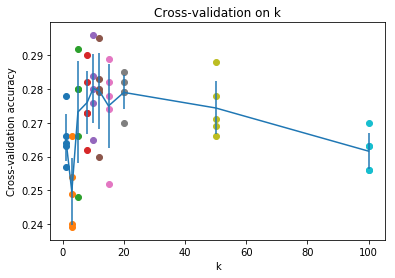

In [19]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [24]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k, num_loops=2)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*: 1,2,4

*Your explanation*: 1 правда, потому что используя 5 ближних соседей вместо одного мы получим более правдивую картину принадлежности объекта. (впрочем, если брать очень много соседей, то все произойдет с точностью наоборот)
2 правда по той же причине.
3 не правда, так как для подсчитывания дистанции используется нелинейная функция
4 правда, так как для классификации необходимо сравнение со всеми образцами тренировки, поэтому тренировочный сет влияет на время классификации